## Mission

La mission est d’aider les équipes de l'entreprise brésilienne Olist à comprendre ses différents types d'utilisateurs. L'idée est d'utiliser des méthodes non supervisées pour regrouper des clients de profils similaires.
Il faut donc fournir à l’équipe Marketing d'Olist une description actionable de segmentation et la logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

#### [Importation du dataset créé, utilsation des features Récence, Fréquence, Montant](#importation-donnees)
 - [Segmentation RFM](#segmentation-rfm)
 - [Segmentation RFMS](#segmentation-rfms)
 

#### [Clustering avec l'algorithme du K-Means](#clustering-avec-lagorithme-de-k-means)
 - [Explication de l'algorithme](#explication-de-lalgorithme)
 - [Preprocessing](#preprocessing)
 - [Méthode du coude avec KElbowVisualizer de Yellowbrick](#méthode-du-coude-avec-kelbowvisualizer-de-yellowbrick)
 - [Coefficient de silhouette](#coefficient-de-silhouette)
 - [Distances intercluster](#distances-intercluster)
 - [Radar plot: diagramme en toile d'araignée](#plot-radar-diagramme-en-étoile-daraignée)


#### [Autres méthodes de clustering](#autres-méthodes-de-clustering)
 - [CAH: Agglomerative Clustering (Clustering Hiérarchique)](#cah-agglomerative-clustering-clustering-hiérarchique)
 - [DBSCAN (Density-Based Spatial Clustering of Applications with Noise)](#dbscan-density-based-spatial-clustering-of-applications-with-noise)




<a id='importation-donnees'></a>
### Importation du dataset étendu

#### Segmentation RFM

La [segmentation RFM](https://www.definitions-marketing.com/definition/segmentation-rfm/) repose sur 3 features:

- la **Récence** (date de la dernière commande par rapport à la dernière date du dataset)
- la **Fréquence** des commandes (nombre de commandes par client)
- le **Montant** (montant total par client)

https://www.definitions-marketing.com/definition/segmentation-rfm/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

clients = pd.read_csv("olist/clients.csv")
clients.shape


(92294, 13)

In [2]:
clients.sample(5)

,customer_unique_id,dernier_achat,Frequence,Montant,Satisfaction,Recence,delivery_days,delivery_error_days,favourite_category,favourite_month,customer_state,distance_customer_seller,freight_value
84317,e9aef7d89fa190dfc65ac148393de711,2018-05-06 20:14:45,1,162.55,5.0,163,8.0,-21.0,sport,5,SP,932.401246,23.550000
39175,6c4f22a436757085432e2615eef0bbc8,2018-08-06 18:32:29,1,81.26,5.0,71,11.0,-3.0,home_furniture,8,PR,714.130103,41.260000
48105,854c92cd9e0bcac4eb1ba8876a1c7907,2018-05-17 15:46:19,1,120.13,5.0,152,4.0,-8.0,sport,5,SP,67.159260,8.130000
43340,7801badc78d7bb52422028d088d6edbd,2018-08-02 12:06:02,1,162.81,2.0,76,11.0,-1.0,sport,8,PR,1199.932390,22.910000
63100,aeb6e243a46bb92926715a3de3a41f4c,2018-05-03 00:03:53,3,534.63,3.0,167,7.0,-14.0,technology,5,SP,313.690113,12.803333


In [3]:
FEATURES_RFM = ['Recence', 'Frequence', 'Montant']
clients[FEATURES_RFM].quantile(q=[0.25, 0.5, 0.75])

,Recence,Frequence,Montant
0.25,162.0,1.0,63.620
0.50,267.0,1.0,112.760
0.75,394.0,1.0,201.215


In [4]:
clients['Frequence'].value_counts()

Frequence
1     78486
2     10270
3      1877
4       871
5       298
6       265
7        72
8        39
12       23
10       19
11       18
9        18
14        7
15        6
13        6
24        4
20        3
21        3
16        2
18        1
19        1
22        1
26        1
38        1
75        1
35        1
Name: count, dtype: int64

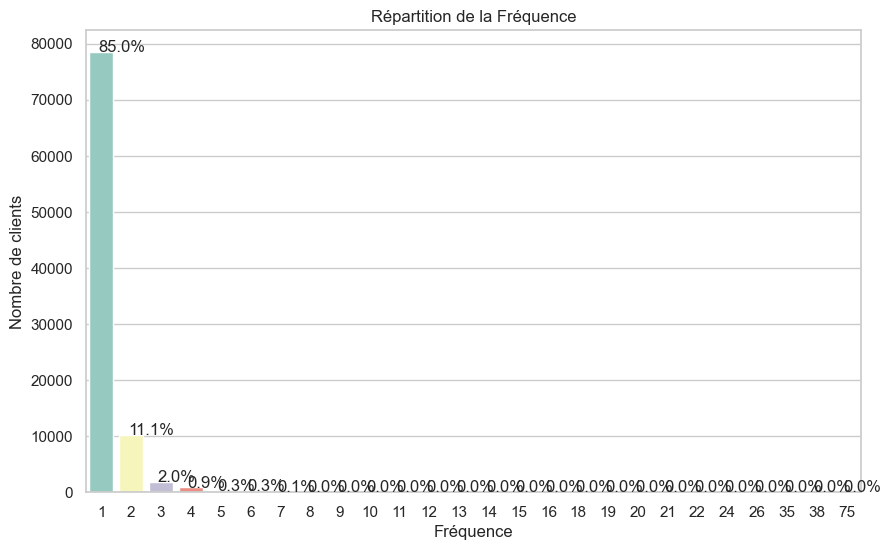

In [5]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(x='Frequence', data=clients, palette="Set3")

total = len(clients['Frequence'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 5
    ax.annotate(percentage, (x, y))

plt.xlabel('Fréquence')
plt.ylabel('Nombre de clients')
plt.title('Répartition de la Fréquence')
plt.show()


In [6]:
pd.cut(clients['Frequence'], bins=[0, 1, 2, 100],
       labels=[1, 2, 3]).value_counts()

Frequence
1    78486
2    10270
3     3538
Name: count, dtype: int64

In [7]:
def calc_rfm_segmentation(df: pd.DataFrame, cluster_col='cluster_category'):
    """
    Calculate scores and cluster labels for RFM Segmentation.
    - Based on https://gist.github.com/Anugrahn/88471aaeec74948e8ade360f80fef996
    """
    rfm = df[['Recence', 'Frequence', 'Montant']].copy()

    rfm['R'] = pd.qcut(rfm['Recence'], q=4, labels=[4, 3, 2, 1]).astype(int)
    rfm['F'] = pd.cut(rfm['Frequence'], bins=[
                      0, 1, 2, 100], labels=[1, 2, 3]).astype(int)
    rfm['M'] = pd.qcut(rfm['Montant'], q=4,
                       labels=[1, 2, 3, 4]).astype(int)

    def join_rfm(x):
        """Calculation for RFM score group (R+F+M)"""
        return f"{x['R']:.0f}{x['F']:.0f}{x['M']:.0f}"
    rfm['RFM_Segment_Concat'] = rfm.apply(join_rfm, axis=1)

    rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

    def rfm_level(row):
        """Custom segmentation label based on RFM score"""
        if row['RFM_Score'] >= 9:
            return "Stars"
        elif (row['RFM_Score'] >= 8) and (row['RFM_Score'] < 10):
            return 'Champions'
        elif (row['RFM_Score'] >= 7) and (row['RFM_Score'] < 8):
            return 'Loyaux'
        elif (row['RFM_Score'] >= 6) and (row['RFM_Score'] < 7):
            return 'Loyalistes potentiels'
        elif (row['RFM_Score'] >= 5) and (row['RFM_Score'] < 6):
            return 'Potentiels'
        elif (row['RFM_Score'] >= 4) and (row['RFM_Score'] < 5):
            return 'A réactiver'
        else:
            return 'A risque'

    rfm[cluster_col] = rfm.apply(rfm_level, axis=1)
    return rfm


clients_rfm = calc_rfm_segmentation(clients)
clients_rfm.sample(5)


,Recence,Frequence,Montant,R,F,M,RFM_Segment_Concat,RFM_Score,cluster_category
41775,228,1,249.04,3,1,4,314,8,Champions
1479,238,1,90.28,3,1,2,312,6,Loyalistes potentiels
76898,323,2,177.38,2,2,3,223,7,Loyaux
11454,129,1,119.57,4,1,3,413,8,Champions
53925,76,1,40.76,4,1,1,411,6,Loyalistes potentiels


In [8]:
clients_rfm[['RFM_Score', 'cluster_category']].value_counts().sort_values(ascending=False)

RFM_Score  cluster_category     
6          Loyalistes potentiels    20624
7          Loyaux                   16563
5          Potentiels               16552
8          Champions                11997
4          A réactiver              11199
9          Stars                     6552
3          A risque                  5641
10         Stars                     2380
11         Stars                      786
Name: count, dtype: int64

In [9]:
df_rfm_segments = clients_rfm.groupby('cluster_category').agg({
    'Recence': 'mean',
    'Frequence': 'mean',
    'Montant': 'mean',
    'R': ['min', 'max'],
    'F': ['min', 'max'],
    'M': ['min', 'max'],
    'RFM_Segment_Concat': set,
    'RFM_Score': ['min', 'max'],
    'cluster_category': ['count'],
}).sort_values(by=('RFM_Score', 'max'))
df_rfm_segments = df_rfm_segments.rename(
    columns={'cluster_category': 'nb_clients'}).reset_index()
total_clients = df_rfm_segments['nb_clients'].sum()
df_rfm_segments['cluster_percentage'] = df_rfm_segments['nb_clients'] / \
    total_clients * 100
df_rfm_segments

cluster_category     Recence Frequence     Montant   R       F      \
                                mean      mean        mean min max min max   
0               A risque  502.248360  1.000000   43.746499   1   1   1   1   
1            A réactiver  412.050362  1.017055   64.520886   1   2   1   2   
2             Potentiels  342.935959  1.037216   89.143665   1   3   1   3   
3  Loyalistes potentiels  272.151571  1.069822  152.200554   1   4   1   3   
4                 Loyaux  232.261668  1.178349  211.716779   1   4   1   3   
5              Champions  193.191381  1.406518  329.072086   1   4   1   3   
6                  Stars  150.862214  2.156719  662.313593   2   4   1   3   

    M                                     RFM_Segment_Concat RFM_Score      \
  min max                                                set       min max   
0   1   1                                              {111}         3   3   
1   1   2                                    {211, 121, 112}         4   4   
2   1   3                     {122, 212, 311, 113, 221, 131}         5   5   
3   1   4      {213, 132, 231, 312, 411, 114, 123, 321, 222}         6   6   
4   1   4  {322, 331, 313, 124, 232, 421, 133, 214, 223, ...         7   7   
5   1   4      {323, 332, 134, 314, 422, 233, 413, 431, 224}         8   8   
6   2   4  {432, 434, 324, 423, 333, 433, 334, 414, 424, ...         9  11   

  nb_clients cluster_percentage  
       count                     
0       5641           6.111990  
1      11199          12.134050  
2      16552          17.933994  
3      20624          22.345981  
4      16563          17.945912  
5      11997          12.998678  
6       9718          10.529395

Les loyalistes potentiels sont les plus nombreux (22%) devant les clients potentiels (18%).  
Les clients à risque sont assez peu nombreux (6%).  
Les clients stars représentent 10% de la clientèle.

In [10]:
!python3 -m pip install squarify

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


<Figure size 1000x800 with 0 Axes>

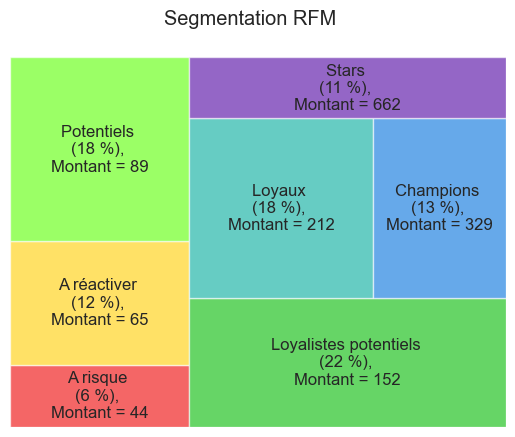

In [11]:
import squarify
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_treemap(df_segments: pd.DataFrame, cluster_col='cluster_category', pct_col='cluster_percentage', colormap=None, figsize=(10, 8)):

    cluster_id_numeric = (
        cluster_col in df_segments.select_dtypes('number').columns)
    cluster_id_categoric = (
        cluster_col in df_segments.select_dtypes('category').columns)
    if cluster_id_numeric or cluster_id_categoric:
        df_segments[cluster_col] = [
            f'seg. {i}' for i in df_segments[cluster_col]]
    df_segment_labels = list(df_segments[cluster_col])
    if colormap is None:
        n = len(df_segments)
        df_segment_colors = sns.color_palette(
            'nipy_spectral_r', n_colors=n).as_hex()
        colormap = dict(zip(df_segment_colors, df_segment_labels))

    df_summary = df_segments[[cluster_col, pct_col, 'Montant']]

    def row_label(row):
        return (f"{row[cluster_col]} \n({row[pct_col]:.0f} %), "
                + f"\nMontant = {row['Montant']:.0f}")
    
    df_treemap = df_summary.sort_values(by='Montant')
    df_treemap['text'] = df_treemap.apply(lambda row: row_label(row), axis=1)

     # Création de la figure avec une taille personnalisée
    fig = plt.figure(figsize=figsize)
    
    # Création des axes Montant et Fréquence
    fig, ax = plt.subplots()
    squarify.plot(sizes=df_treemap[pct_col], ax=ax,
                  label=df_treemap['text'], alpha=.6,
                  color=colormap)
    
    # Ajout de l'axe horizontal "Montant"
    # ax.text(0.5, -0.03, 'Montant', fontsize=12, ha='center')
    
    # Ajout de l'axe vertical "Fréquence"
    # ax.text(-0.03, 0.5, 'Fréquence', fontsize=12, va='center', rotation='vertical')
    
    plt.axis('off')

# Exemple d'utilisation :
plot_treemap(df_rfm_segments.droplevel(1, axis=1).reset_index())
plt.suptitle('Segmentation RFM')

# Afficher le graphique
plt.show()


#### Segmentation RFMS

In [12]:
FEATURES_RFMS = ['Recence', 'Frequence', 'Montant', 'Satisfaction']
clients[FEATURES_RFMS].quantile(q=[0.25, 0.5, 0.75])

,Recence,Frequence,Montant,Satisfaction
0.25,162.0,1.0,63.620,4.0
0.50,267.0,1.0,112.760,5.0
0.75,394.0,1.0,201.215,5.0


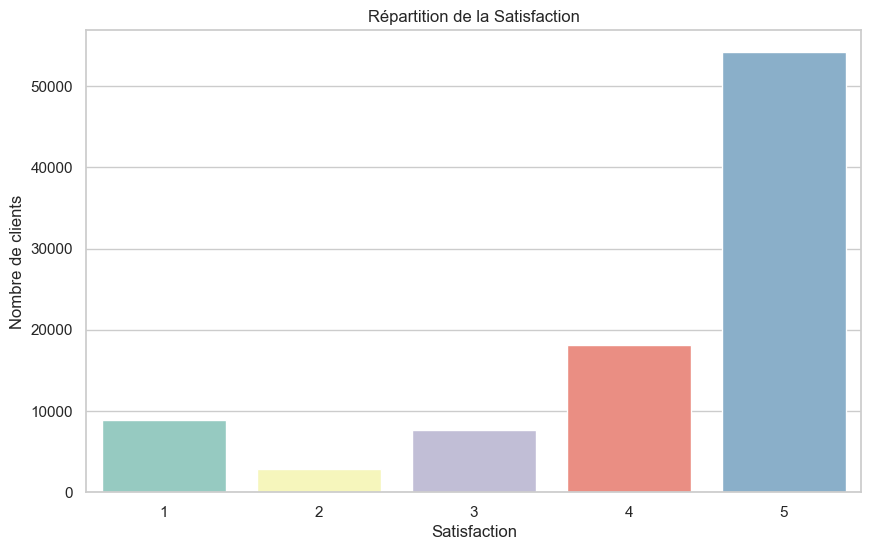

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(x='Satisfaction', data=clients, palette="Set3", order=[1, 2, 3, 4, 5])

total = len(clients['Satisfaction'])

for p in ax.patches:
    # Vérifiez si la valeur de l'axe x est dans la liste des valeurs pour lesquelles vous voulez afficher les pourcentages
    if p.get_x() in [0, 1, 2, 3, 4]:
        percentage = '{:.0f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 5
        ax.annotate(percentage, (x, y))

plt.xlabel('Satisfaction')
plt.ylabel('Nombre de clients')
plt.title('Répartition de la Satisfaction')
plt.show()


In [14]:
filtered_clients = clients[clients['Satisfaction'].isin([1, 2, 3, 4, 5])]
satisfaction_counts = filtered_clients['Satisfaction'].value_counts(normalize=True) * 100
satisfaction_counts = satisfaction_counts.sort_index()
print("Répartition de la Satisfaction (en pourcentage) :")
print(satisfaction_counts)


Répartition de la Satisfaction (en pourcentage) :
Satisfaction
1.0     9.692395
2.0     3.064033
3.0     8.309484
4.0    19.760558
5.0    59.173530
Name: proportion, dtype: float64


In [15]:
pd.cut(clients['Satisfaction'], bins=[0, 3, 4, 5],
       labels=[1, 2, 3]).value_counts()

Satisfaction
3    54547
1    19443
2    18304
Name: count, dtype: int64

In [16]:
def calc_rfms_segmentation(df: pd.DataFrame, cluster_col='cluster_category'):

    rfms = df[['Recence', 'Frequence', 'Montant', 'Satisfaction']].copy()

    rfms['R'] = pd.qcut(rfms['Recence'], q=4, labels=[4, 3, 2, 1]).astype(int)
    rfms['F'] = pd.cut(rfms['Frequence'], bins=[
                      0, 1, 2, 100], labels=[1, 2, 3]).astype(int)
    rfms['M'] = pd.qcut(rfms['Montant'], q=4,
                       labels=[1, 2, 3, 4]).astype(int)
    rfms['S'] = pd.cut(rfms['Satisfaction'], bins=[0, 3, 4, 5],
       labels=[1, 2, 3]).astype(int)

    def join_rfms(x):
        """Calculation for RFMS score group (R+F+M+S)"""
        return f"{x['R']:.0f}{x['F']:.0f}{x['M']:.0f}{x['S']:.0f}"
    rfms['RFMS_Segment_Concat'] = rfms.apply(join_rfms, axis=1)

    rfms['RFMS_Score'] = rfms[['R', 'F', 'M', 'S']].sum(axis=1)

    def rfms_level(row):
        """Custom segmentation label based on RFMS score"""
        if row['RFMS_Score'] >= 11:
            return "Stars"
        elif (row['RFMS_Score'] >= 10) and (row['RFMS_Score'] < 12):
            return 'Champions'
        elif (row['RFMS_Score'] >= 9) and (row['RFMS_Score'] < 10):
            return 'Loyaux'
        elif (row['RFMS_Score'] >= 8) and (row['RFMS_Score'] < 9):
            return 'Loyalistes potentiels'
        elif (row['RFMS_Score'] >= 7) and (row['RFMS_Score'] < 8):
            return 'Potentiels'
        elif (row['RFMS_Score'] >= 6) and (row['RFMS_Score'] < 7):
            return 'A réactiver'
        else:
            return 'A risque'

    rfms[cluster_col] = rfms.apply(rfms_level, axis=1)
    return rfms


clients_rfms = calc_rfms_segmentation(clients)
clients_rfms.sample(5)


,Recence,Frequence,Montant,Satisfaction,R,F,M,S,RFMS_Segment_Concat,RFMS_Score,cluster_category
37887,216,1,97.38,5.0,3,1,2,3,3123,9,Loyaux
43178,146,2,114.25,5.0,4,2,3,3,4233,12,Stars
15161,197,1,58.16,5.0,3,1,1,3,3113,8,Loyalistes potentiels
84307,243,1,134.45,4.0,3,1,3,2,3132,9,Loyaux
20578,249,1,63.27,5.0,3,1,1,3,3113,8,Loyalistes potentiels


In [17]:
df_rfms_segments = clients_rfms.groupby('cluster_category').agg({
    'Recence': 'mean',
    'Frequence': 'mean',
    'Montant': 'mean',
    'Satisfaction': 'mean',
    'R': ['min', 'max'],
    'F': ['min', 'max'],
    'M': ['min', 'max'],
    'S': ['min', 'max'],
    'RFMS_Segment_Concat': set,
    'RFMS_Score': ['min', 'max'],
    'cluster_category': ['count'],
}).sort_values(by=('RFMS_Score', 'max'))
df_rfms_segments = df_rfms_segments.rename(
    columns={'cluster_category': 'nb_clients'}).reset_index()
total_clients = df_rfms_segments['nb_clients'].sum()
df_rfms_segments['cluster_percentage'] = df_rfms_segments['nb_clients'] / \
    total_clients * 100
df_rfms_segments

cluster_category     Recence Frequence     Montant Satisfaction   R  \
                                mean      mean        mean         mean min   
0               A risque  458.062716  1.008762   53.592585     2.613097   1   
1            A réactiver  418.572527  1.015153   64.749325     3.649720   1   
2             Potentiels  357.767386  1.042894   94.666690     3.893233   1   
3  Loyalistes potentiels  309.267413  1.081182  133.292255     4.129930   1   
4                 Loyaux  255.243370  1.153389  199.446766     4.360324   1   
5              Champions  215.983256  1.313786  289.758301     4.443678   1   
6                  Stars  161.089178  1.794870  486.685238     4.655214   1   

        F       M       S      \
  max min max min max min max   
0   2   1   2   1   2   1   2   
1   3   1   3   1   3   1   3   
2   4   1   3   1   4   1   3   
3   4   1   3   1   4   1   3   
4   4   1   3   1   4   1   3   
5   4   1   3   1   4   1   3   
6   4   1   3   1   4   1   3   

                                 RFMS_Segment_Concat RFMS_Score      \
                                                 set        min max   
0                     {1121, 1111, 1211, 2111, 1112}          4   5   
1  {2112, 1131, 1221, 1212, 2211, 2121, 1311, 311...          6   6   
2  {2122, 1231, 1321, 1141, 2221, 2212, 3121, 131...          7   7   
3  {3131, 3113, 1142, 1313, 1322, 2213, 1223, 212...          8   8   
4  {1332, 3321, 3132, 1242, 2133, 4131, 3213, 323...          9   9   
5  {2323, 3223, 2233, 4231, 3313, 3133, 4213, 214...         10  10   
6  {3242, 4322, 4232, 3243, 3342, 4133, 2333, 424...         11  14   

  nb_clients cluster_percentage  
       count                     
0       4337           4.699114  
1       9107           9.867380  
2      14221          15.408369  
3      17430          18.885301  
4      18515          20.060892  
5      13557          14.688929  
6      15127          16.390015

Étant donné le haut niveau de satisfaction, on a une segmentation un peu différente, un peu plus orientée vers les meilleures catégories.  
Les loyaux sont désormais les plus nombreux (contre les loyalistes potentiels avec la segmentation RFM).  
Les clients à risque restent peu nombreux et diminuent même (de 6 à 4,6%)  
Les clients stars augmentent par rapport à la segmentation RFM (ils passent de 11 à 16%).  

<Figure size 1000x800 with 0 Axes>

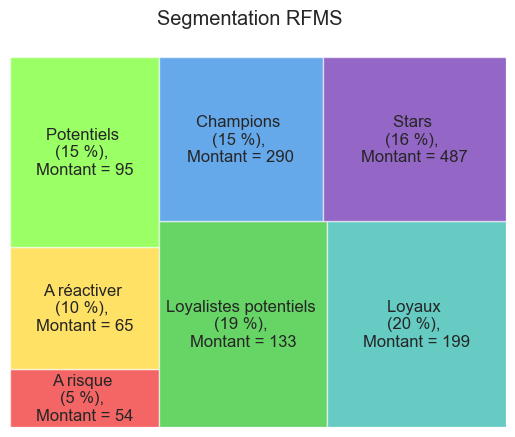

In [18]:
plot_treemap(df_rfms_segments.droplevel(1, axis=1).reset_index())
plt.suptitle('Segmentation RFMS')

# Afficher le graphique
plt.show()

### D'autres clusterings

L'algorithme K-Means représente un modèle de base mais il n'est pas suffisant pour faire un clustering pertinent : le fait que la Fréquence soit de 1 à 85% est trop important, la Récence et la Fréquence n'ont pas suffisamment d'intérêt pour être les quasi-seules features prises en compte.

### Clustering avec l'agorithme de K-Means

#### Explication de l'algorithme

K-Means: un des algorithmes de clustering les plus répandus.  
Après avoir initialisé des centroïdes en prenant des données au hasard dans le dataset, K-means alterne plusieurs fois ces étapes pour optimiser les centroïdes et leurs groupes:  
- Regroupement de chaque objet autour du centroïde le plus proche.
- Réajustement de chaque centroïde selon la moyenne des descripteurs de son groupe.   

#### Preprocessing

On met de côté les variables qui ne nous intéressent plus, parmi elles les variables catégorielles restantes qui n'ont pas d'intérêt dans un K-Means.

In [19]:
clients.drop(["customer_unique_id",
           "favourite_category",
           "customer_state", "dernier_achat"], axis=1, inplace=True)

In [20]:
clients.columns

Index(['Frequence', 'Montant', 'Satisfaction', 'Recence', 'delivery_days',
       'delivery_error_days', 'favourite_month', 'distance_customer_seller',
       'freight_value'],
      dtype='object')

In [21]:
numerical_features = list(clients.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['Frequence',
 'Montant',
 'Satisfaction',
 'Recence',
 'delivery_days',
 'delivery_error_days',
 'favourite_month',
 'distance_customer_seller',
 'freight_value']

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

#### Méthode du coude avec KElbowVisualizer de Yellowbrick  
 KElbowVisualizer implémente la méthode du «coude» pour sélectionner le nombre optimal de clusters en ajustant le modèle K-Means avec une plage de valeurs pour K. Si le graphique en courbes ressemble à un bras, alors le coude (le point d'inflexion sur la courbe) est une bonne indication du nombre de K optimal.

In [ ]:
!python3 -m pip install yellowbrick

On crée un pipeline sklearn pour enchaîner le traitement du preprocessor et la méthode de visualisation du coude.  
On utilisera également un pipeline pour inclure le preprocessor à la visualisation des silhouettes des clusters, et à la visualisation de la distance qui les sépare.  

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: F

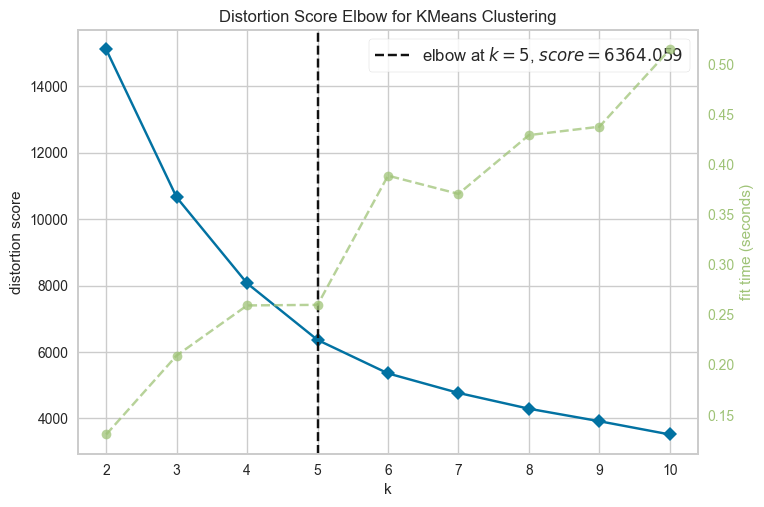

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans


X = clients.copy()

kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Grâce à la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segementation en K = 5 clusters serait la meilleure option.

#### Coefficient de silhouette
Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters. 

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


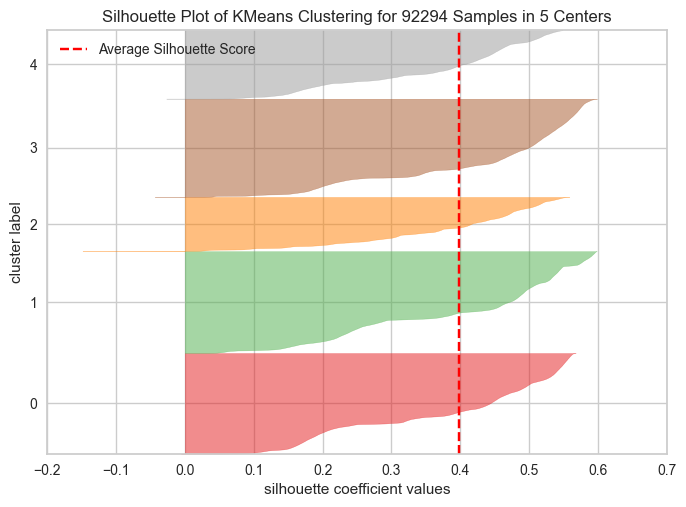

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 92294 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

#### Distances intercluster

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


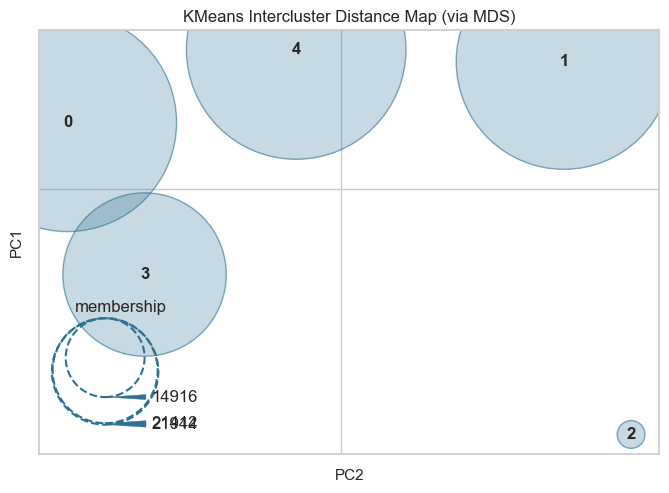

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [26]:
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Des clusters se chevauchent dans la visualisation, cela peut être dû à une complexité intrinsèque des données qui comportent des chevauchements naturels, à un choix incorrect du nombre de clusters ou à un problème d'initialisation des centroïdes.  
De plus, un cluster est à la fois très éloigné des autres et beaucoup plus petit: cela peut être dû à un point aberrant, à un groupe spécialisé, à une erreur de clustering ou à des données très hétérogènes.  

#### Plot radar: diagramme en étoile d'araignée


In [27]:
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
clients["kmeans_label"] = kmeans_labels

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) 
X_scaled["kmeans_label"] = kmeans_labels
X_scaled.reset_index(drop=True, inplace=True)
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,Frequence,Montant,Satisfaction,Recence,delivery_days,delivery_error_days,favourite_month,distance_customer_seller,freight_value
kmeans_label,,,,,,,,,
0,0.002643,0.001657,0.887540,0.259209,0.056317,0.402698,0.136567,0.066379,0.047655
1,0.002941,0.001676,0.891696,0.686014,0.051752,0.394327,0.341537,0.072235,0.047169
2,0.005545,0.002806,0.062708,0.340630,0.092629,0.423114,0.436833,0.077595,0.052498
3,0.002835,0.001707,0.892669,0.451244,0.054338,0.401311,0.835908,0.070379,0.047200
4,0.002702,0.001757,0.906193,0.088148,0.038292,0.399664,0.499187,0.064958,0.052411


In [ ]:
!python3 -m pip install plotly


In [ ]:
!python3 -m  pip install --upgrade nbformat

In [31]:
import plotly.graph_objs as go

def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [32]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

Cluster 0: temps de livraison et d'erreur courts, taxes élevées  
Cluster 1: Satisfaction élevée, temps de livraison et d'erreur courts, dernier achat il y a longtemps    
Cluster 2: Satisfaction basse, temps de livraison et d'erreur élevés, montants inmportants  
Cluster 3: Satisfaction élevée, temps de livraison et d'erreur courts, achats en décembre        
Cluster 4: Satisfaction élevée, temps de livraison et d'erreur courts, achats récents        

In [33]:
clients.drop('kmeans_label', axis=1, inplace=True)

### Autres méthodes de clustering

- CAH: Agglomerative Clustering (Clustering Hiérarchique)
- DBSCAN  

 CAH construit une hiérarchie de clusters en fusionnant progressivement les clusters les plus proches, tandis que DBSCAN identifie les clusters en se basant sur la densité des points dans l'espace.

<https://scikit-learn.org/stable/modules/clustering.html>

| Method name | Parameters | Scalability | Usecase | Geometry (metric used) |
|-----------|-----------|-----------|-----------|-----------|
| CAH = Agglomerative clustering   | number of clusters or distance threshold, linkage type, distance   | Large n_samples and n_clusters   | Many clusters, possibly connectivity constraints, non Euclidean distances, transductive   | Any pairwise distance   |
| DBSCAN   | 	neighborhood size   | Very large n_samples, medium n_clusters   | Non-flat geometry, uneven cluster sizes, outlier removal,  transductive   | Distances between nearest points   |

### CAH: Agglomerative Clustering (Clustering Hiérarchique)


CAH est une méthode de clustering qui commence par considérer chaque point de données comme un cluster individuel.
Ensuite, elle fusionne progressivement les clusters les plus proches les uns des autres pour former des clusters plus grands.  
Ce processus se poursuit jusqu'à ce qu'un seul cluster global soit obtenu.  
L'arbre de regroupement résultant, appelé dendrogramme, permet de visualiser la hiérarchie des clusters.  
CAH peut être utilisée pour identifier des structures de regroupement dans des données en fonction de la proximité entre les points.  

Analyse de clustering hiérarchique sur un échantillon de données clients et affichage d'un dendrogramme pour visualiser la structure hiérarchique des regroupements de clients en fonction de leurs caractéristiques numériques.

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
sample_size = min(10000, len(clients))
clients_sample = clients.sample(sample_size, random_state=0)
Z = linkage(clients_sample.select_dtypes('number'), 'ward')

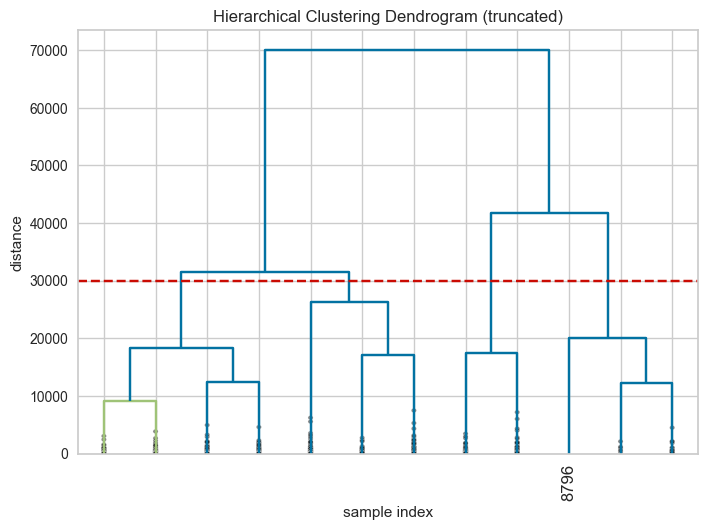

In [35]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    color_threshold=10000,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(30000, c='r', ls='--')
plt.show()

In [36]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(clf:AgglomerativeClustering, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(clf.children_.shape[0])
    n_samples = len(clf.labels_)
    for i, merge in enumerate(clf.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [clf.children_, clf.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Fonctions utiles pour extraire et filtrer les paramètres spécifiques d'une étape nommée dans le pipeline 

In [37]:
def filtered_dict(d, filter_string):
    result = {k: v for (k, v) in d.items() if filter_string in k}
    return result


def get_named_step_params(pipeline, named_step):
    params_ = pipeline.get_params()
    return filtered_dict(params_, named_step)


Impression des paramètres du modèle d'apprentissage non supervisé

Utilisation de QuantileTransformer dans la phase de prétraitement (transformation des données d'entrée en suivant une distribution normale) et AgglomerativeClustering dans la phase de clustering pour effectuer un clustering hiérarchique sur des données prétraitées avec une transformation quantile

In [38]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import AgglomerativeClustering

# agglomerative clustering est rélativement lent, on réduit le taille d'echantillon 
sample_size = min(10000, len(clients))
df_clients_sample = clients.sample(sample_size, random_state=0)

model_cah = Pipeline(steps=[
    # L'étape de prétraitement ('preprocessor') utilise QuantileTransformer pour transformer les données d'entrée en suivant une distribution normale.
    ('preprocessor', QuantileTransformer(
        output_distribution='normal', random_state=0)),
    # setting distance_threshold=0 ensures we compute the full tree.
    # L'étape de clustering ('clf') utilise AgglomerativeClustering pour effectuer le clustering hiérarchique agglomératif.
    ('clf', AgglomerativeClustering(compute_distances=True))
])
print(get_named_step_params(model_cah, 'clf'))


{'clf': AgglomerativeClustering(compute_distances=True), 'clf__affinity': 'deprecated', 'clf__compute_distances': True, 'clf__compute_full_tree': 'auto', 'clf__connectivity': None, 'clf__distance_threshold': None, 'clf__linkage': 'ward', 'clf__memory': None, 'clf__metric': None, 'clf__n_clusters': 2}


In [39]:
clients_sample.select_dtypes('number').columns


Index(['Frequence', 'Montant', 'Satisfaction', 'Recence', 'delivery_days',
       'delivery_error_days', 'favourite_month', 'distance_customer_seller',
       'freight_value'],
      dtype='object')

Mesure de la stabilité des clusters générés par le modèle clf (abréviaton de classifier, clusterer)  
- stability_score : Moyenne des scores de stabilité ajustés.
- stability_score_std : Écart type des scores de stabilité ajustés.
- stability_sample_sizes : Taille de l'échantillon utilisé pour le calcul.
- stability_time : Temps total écoulé pour l'exécution de la fonction.

In [40]:
from sklearn.base import clone, BaseEstimator
from sklearn import metrics
from time import time



def calc_cluster_stability(df: pd.DataFrame, clf: BaseEstimator, n_iter=10, sample_size=5000):
    # code based on https://github.com/scikit-learn/scikit-learn/issues/1091
    if not sample_size is None:
        sample_size = min(sample_size, len(df))
        df = pd.DataFrame(df).sample(sample_size)
    labels = []

    start = time()
    clf = clone(clf)
    for i in range(n_iter):
        if hasattr(clf, 'random_state'):
            # randomize estimator if possible
            clf.random_state = np.random.randint(0, 1e5)
        clf.fit(df)
        if hasattr(clf, 'labels_'):
            labels.append(clf.labels_)
        else:
            labels.append(clf.predict(df))

    scores = []
    # compare all scores to get average
    for i in range(0, n_iter - 1):
        for j in range(i + 1, n_iter):
            score = metrics.adjusted_rand_score(labels[i], labels[j])
            scores.append(score)

    res = {}
    res['stability_score'] = np.round(np.mean(scores), 2)
    res['stability_score_std'] = np.round(np.std(scores), 2)
    res['stability_sample_sizes'] = int(sample_size)
    res['stability_time'] = round(time()-start, 2)
    return res

Mesure de la qualité des clusters générés par le modèle de clustering en utilisant le score de silhouette comme métrique d'évaluation:
- silhouette_score : Moyenne des scores de silhouette calculés.
- silhouette_score_std : Écart type des scores de silhouette calculés.
- silhouette_sample_sizes : Taille de l'échantillon utilisée pour le calcul.
- silhouette_time : Temps total écoulé pour l'exécution de la fonction.

In [41]:
from sklearn.cluster import KMeans
from sklearn.base import clone, BaseEstimator
from sklearn import metrics


def calc_silhouette_score(df: pd.DataFrame, clf: BaseEstimator, n_iter=10, sample_size=1000):
    """
    Calculate mean and standard deviation of silhouette score for a model
    Parameters
    ----------
    df: scaled or unscaled features
    clf: model to fit labels on scaled features, or pipeline to scale and fit features 
       If df is unscaled, clf contains named steps 'preprocessor' to scale data, and 'clf' to fit the scaled data
       If df is scaled, clf can either be pipeline as above, or classifier (KMeans, DBSCAN etc)
    """
    if not sample_size is None:
        sample_size = min(sample_size, len(df))
    else:
        sample_size = min(2000, max(1000, len(df)//10))
    clf = clone(clf)
    df = df.copy()
    if hasattr(clf, 'named_steps'):
        if hasattr(clf.named_steps, 'preprocessor') & hasattr(clf.named_steps, 'clf'):
            # c'est un pipeline on sépare le preprocessor et classifier
            preprocessor = clf.named_steps['preprocessor']
            df = preprocessor.fit_transform(df)
            clf = clf.named_steps['clf']

    silh = []
    start_silh = time()
    for i in range(n_iter):
        if hasattr(clf, 'random_state'):
            # randomize estimator if possible
            clf.random_state = np.random.randint(0, 1e5)
        df_sample = pd.DataFrame(df).sample(sample_size)
        clf.fit(df_sample)
        if hasattr(clf, 'labels_'):
            labels = clf.labels_
        else:
            labels.append(clf.predict(df))
        if pd.Series(labels).nunique() > 1:
            silh.append(metrics.silhouette_score(df_sample, labels))
    res = {}
    if len(silh) > 0:
        res['silhouette_score'] = np.round(np.mean(silh), 2)
        res['silhouette_score_std'] = np.round(np.std(silh), 2)
        res['silhouette_sample_sizes'] = int(sample_size)
        res['silhouette_time'] = round(time()-start_silh, 2)
    return res

Évaluation d'un modèle de clustering:  
- calcul sur différentes combinaisons de paramètres, 
- calcul de diverses métriques d'évaluation (distorsion, score Davies-Bouldin, score Calinski-Harabasz, score de silhouette (si activé), stabilité des clusters (si activée)) 
- stockage des résultats dans un dataframe 

Pour le Silhouette Score, on cherche la valeur la plus haute possible  
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html 

Pour Calinski-Harabasz, on cherche la valeur la plus haute possible  
https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index

Pour Davies Bouldin, on cherche le score le plus proche de 0 possible.  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#:~:text=Compute%20the%20Davies%2DBouldin%20score,result%20in%20a%20better%20score.  
"The minimum score is zero, with lower values indicating better clustering."



In [42]:
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

model_param_grid = {'clf__n_clusters': range(2, 10)}


def get_classname(estimator):
    return estimator.__class__.__name__


def score_model(df: pd.DataFrame, model,
                param_grid=model_param_grid,
                calc_silhouette=True, calc_stability=True, show_params=False) -> pd.DataFrame:
    """
    Fit les clusters et ajouter des scores sur un dataset
    Parameters
    ----------
    df: data[features]
    model: pipeline with named steps 'preprocessor' and 'clf'
    param_grid: range of hyperparameters to test (prefixed preprocessor__ and clf__)
    calc_silhouette - calculate silhouette scores(chronophage)
    calc_silhouette - calculate stability of clusters (chronophage)
    show_params - if true, show all parameters of model (for debugging)
    Returns
    -------
    dataframe containing scores for all permutations of param_grid 
    """

    # define order of columns
    scores = pd.DataFrame([], columns=[
        'k',
        'distortion_score',
        'davies_bouldin', 'calinski_harabasz',
        'silhouette_score', 'silhouette_score_std',
        'silhouette_sample_sizes', 'silhouette_time',
        'clf', 'preprocessor', 'features'
    ])
    # generate parameter grid for classifier
    param_sets = ParameterGrid(param_grid)

    for params in param_sets:
        # print(f'score model for params = {params}')
        # set model parameters (usually just n_clusters for classifier)
        model.set_params(**params)

        preprocessor = model.named_steps['preprocessor']
        df_scaled = preprocessor.fit_transform(df)

        clf = model.named_steps['clf']
        start_fit_clf = time()
        clf.fit(df_scaled)
        fit_time_clf = round(time()-start_fit_clf, 2)
        labels: pd.Series = pd.Series(clf.labels_)
        k = labels.nunique()
        # size of clusters (as % of total)
        cluster_sizes = np.round((labels.value_counts(
            normalize=True).values*100), 0).astype(int)
        if k > 1:
            print(
                f'params={params}; k={k}; cluster_sizes={list(cluster_sizes)}')
        # inertia = distortion score = mean sum of squared distances to cluster centers
        # clf_params is a dictionary
        clf_params = dict(clf.get_params())
        res = {'k': k,
               'fit time (s)': fit_time_clf,
               'cluster_sizes': cluster_sizes,
               }
        res = dict(**res, **params)
        if k > 1:
            res['distortion_score'] = getattr(clf, 'inertia_', np.NaN)
            res['davies_bouldin'] = metrics.davies_bouldin_score(
                df_scaled, clf.labels_)
            res['calinski_harabasz'] = metrics.calinski_harabasz_score(
                df_scaled, clf.labels_)

            if calc_silhouette:
                # silhouette score basé sur une minimum de 2000 et un maximum de 20000 points
                # supposant que les clusters sont stables et seront approximativement les mêmes
                # plus de 20000 points prend trop de temps
                silh = calc_silhouette_score(df_scaled, clf, sample_size=2000)
                res = dict(**res, **silh)

            if calc_stability:
                stab = calc_cluster_stability(
                    df_scaled, clf, sample_size=20000)
                res = dict(**res, **stab)

        res['clf'] = get_classname(clf)
        res['preprocessor'] = get_classname(preprocessor)

        if show_params:
            # add all parameters to scores
            res['features'] = list(df.columns)
            res['preprocessor_params'] = dict(preprocessor.get_params())
            res['clf_params'] = clf_params

        # scores = scores.append(res, ignore_index=True)
        scores = pd.concat([scores, pd.DataFrame([res])], ignore_index=True)
        scores['k'] = scores['k'].astype(int)
    return scores.dropna(axis=1, how='all')


In [43]:
FEATURES = ['Recence', 'Frequence', 'Montant', 'Satisfaction', 'delivery_error_days', 'freight_value']

In [44]:
param_grid = {
    'clf__linkage': ['single', 'average', 'complete', 'ward'],
    'clf__n_clusters': range(4, 9)
}
scores_cah = score_model(
    df=clients_sample[FEATURES], model=model_cah, param_grid=param_grid)
scores_cah.sort_values(by='silhouette_score', ascending=False).head()


params={'clf__linkage': 'single', 'clf__n_clusters': 4}; k=4; cluster_sizes=[51, 34, 7, 7]
params={'clf__linkage': 'single', 'clf__n_clusters': 5}; k=5; cluster_sizes=[51, 26, 7, 7, 7]
params={'clf__linkage': 'single', 'clf__n_clusters': 6}; k=6; cluster_sizes=[51, 26, 7, 7, 5, 2]
params={'clf__linkage': 'single', 'clf__n_clusters': 7}; k=7; cluster_sizes=[51, 26, 7, 7, 5, 2, 0]
params={'clf__linkage': 'single', 'clf__n_clusters': 8}; k=8; cluster_sizes=[51, 26, 7, 7, 5, 2, 0, 0]
params={'clf__linkage': 'average', 'clf__n_clusters': 4}; k=4; cluster_sizes=[51, 34, 7, 7]
params={'clf__linkage': 'average', 'clf__n_clusters': 5}; k=5; cluster_sizes=[51, 34, 7, 7, 0]
params={'clf__linkage': 'average', 'clf__n_clusters': 6}; k=6; cluster_sizes=[51, 34, 7, 7, 0, 0]
params={'clf__linkage': 'average', 'clf__n_clusters': 7}; k=7; cluster_sizes=[51, 34, 7, 7, 0, 0, 0]
params={'clf__linkage': 'average', 'clf__n_clusters': 8}; k=8; cluster_sizes=[51, 34, 7, 7, 0, 0, 0, 0]
params={'clf__linkage': '

,k,davies_bouldin,calinski_harabasz,silhouette_score,silhouette_score_std,silhouette_sample_sizes,silhouette_time,clf,preprocessor,fit time (s),cluster_sizes,clf__linkage,clf__n_clusters,stability_score,stability_score_std,stability_sample_sizes,stability_time
0,4,0.705776,10862.273064,0.58,0.00,2000,0.97,AgglomerativeClustering,QuantileTransformer,0.74,"[51, 34, 7, 7]",single,4.0,1.0,0.0,10000.0,6.64
1,5,0.717039,11099.262982,0.58,0.01,2000,1.10,AgglomerativeClustering,QuantileTransformer,0.70,"[51, 26, 7, 7, 7]",single,5.0,1.0,0.0,10000.0,6.68
5,4,0.705776,10862.273064,0.58,0.00,2000,1.46,AgglomerativeClustering,QuantileTransformer,3.65,"[51, 34, 7, 7]",average,4.0,1.0,0.0,10000.0,38.40
15,4,0.705776,10862.273064,0.58,0.00,2000,1.43,AgglomerativeClustering,QuantileTransformer,3.12,"[51, 34, 7, 7]",ward,4.0,1.0,0.0,10000.0,33.06
2,6,0.766864,9797.271020,0.57,0.00,2000,0.86,AgglomerativeClustering,QuantileTransformer,0.64,"[51, 26, 7, 7, 5, 2]",single,6.0,1.0,0.0,10000.0,7.21


- Davies-Bouldin (DB) Score (compacité et séparation des clusters)  
Plus le score DB est bas, meilleure est la qualité du clustering. (compacts et séparés)  
- Calinski-Harabasz (CH) Score (critère de Variances Rapportées) :
    Plus le score CH est élevé, meilleure est la qualité du clustering.  
- Silhouette Score 
    Plus le score de silhouette est proche de 1, meilleure est la qualité du clustering. Un score élevé indique que les points de données sont bien séparés entre eux dans leurs clusters respectifs  
- Silhouette Score Std (Écart type du score de silhouette)  
Un écart type plus faible suggère une stabilité plus élevée dans les clusters.
- Silhouette_sample_sizes
Une taille d'échantillon plus grande peut donner une estimation plus précise de la qualité du clustering.  
- Silhouette Time (Temps pour calculer le score de silhouette)  
Plus le temps est court, mieux c'est

Les meilleurs scores sont avec linkage single et k=4  
La méthode de linkage "single" est l'une des méthodes de regroupement utilisées dans l'agglomération hiérarchique. Elle mesure la distance minimale entre tous les points des deux clusters qui fusionnent à chaque étape.  
k=4 signifie que le nombre optimal de clusters pour les données est de 4.

{'clf': AgglomerativeClustering(compute_distances=True, linkage='single', n_clusters=4), 'clf__affinity': 'deprecated', 'clf__compute_distances': True, 'clf__compute_full_tree': 'auto', 'clf__connectivity': None, 'clf__distance_threshold': None, 'clf__linkage': 'single', 'clf__memory': None, 'clf__metric': None, 'clf__n_clusters': 4}
['0', '1', '2', '3']
{'1': 'Seg. 1', '0': 'Seg. 2', '2': 'Seg. 3', '3': 'Seg. 4'}


Text(0.5, 0.98, "Agglomerative clustering, (linkage 'Single', k=4)")

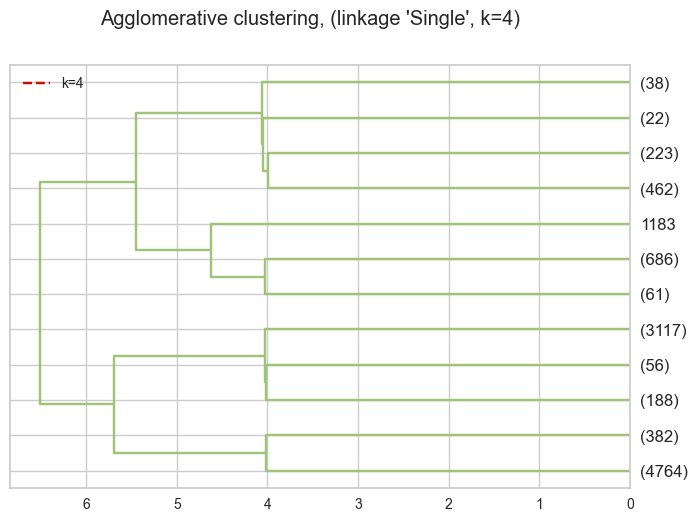

In [45]:

def rename_cluster_labels(df):
    df = df.copy()
    df['cluster_id'] = df['cluster_id'].astype(str)
    old_labels = df.groupby('cluster_id')['Montant'].mean().sort_values(ascending=False).index.astype(str)
    n = len(old_labels)
    new_labels = [f'Seg. {i}' for i in range(1, n + 1)]
    label_map = dict(zip(old_labels, new_labels))
    print(label_map)
    df['cluster_id'] = df['cluster_id'].map(label_map).astype(str)
    return df



def run_agglomerative(df: pd.DataFrame, model=model_cah, n_clusters=4, linkage='ward', color_threshold=10000):
    df=df.select_dtypes('number').copy()
    params = {'clf__linkage': linkage, 'clf__n_clusters': n_clusters}
    model.set_params(**params)
    print(get_named_step_params(model, 'clf'))
    model.fit(df)
    clf: AgglomerativeClustering = model.named_steps['clf']

    plot_dendrogram(clf=clf, truncate_mode="lastp", p=n_clusters*3, orientation='left',
                    color_threshold=color_threshold)
    plt.axvline(color_threshold, c='r', ls='--', label=f'k={n_clusters}')

    df['cluster_id'] = clf.labels_
    df['cluster_id']=df['cluster_id'].astype(str)
    print(sorted(list(df['cluster_id'].unique())))
    return df


client_clusters_cah = run_agglomerative(
    df_clients_sample,
    model_cah, n_clusters=4, linkage='single', color_threshold=8500)

client_clusters_cah=client_clusters_cah.pipe(rename_cluster_labels)
plt.legend(loc=2)
plt.suptitle("Agglomerative clustering, (linkage 'Single', k=4)")


In [46]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour s'assurer que les colonnes existent
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols

Aggrégation des clusters

In [47]:
def agg_top(x):
    """return most frequent x"""
    return x if len(x) == 1 else x.value_counts().index[0]

def group_clusters(df: pd.DataFrame, cluster_col='cluster_id'):
    """Aggregate clusters on numeric and categorical columns"""
    df = df.copy()
    df[cluster_col] = df[cluster_col].astype('category')

    # effectif et fréquence des clusters
    df_cluster_sizes = df.groupby(cluster_col).agg(
        cluster_size=(cluster_col, 'count'))
    n = len(df)
    df_cluster_sizes['cluster_pct'] = np.round(
        df_cluster_sizes['cluster_size']/n * 100, 2)
    # df_cluster_size=(df[cluster_col].value_counts(normalize=False)*100).to_frame(name='cluster_size')
    # df_cluster_pct=(df[cluster_col].value_counts(normalize=True)*100).to_frame(name='cluster_pct')

    # moyennes des colonnes numériques
    num_cols = df.select_dtypes('number').columns
    df_cluster_means = df.groupby(cluster_col)[num_cols].mean()
    df_agg = df_cluster_sizes.join(df_cluster_means)

    #
    obj_cols = df.select_dtypes('object').columns
    if len(obj_cols) > 0:
        df_cluster_max = df.groupby(cluster_col)[obj_cols].agg(agg_top)
        df_agg = df_agg.join(df_cluster_max)

    if 'Montant' in df_agg.columns:
        df_agg = df_agg.sort_values(by='Montant', ascending=False)
    df_agg = df_agg.reset_index()
    df_agg[cluster_col]=df_agg[cluster_col].astype(str)
    return df_agg

Standardisation des valeurs des colonnes pour mettre toutes les caractéristiques à la même échelle

In [48]:
def standard_scores(df: pd.DataFrame, features=FEATURES,
                    scaler=None, min_score=1, max_score=5) -> pd.DataFrame:
    """
    Standardise scale of feature columns
    - Apply to cluster group summary for rapidity
    Returns dataframe with same columns, with feature scores standardised
    """
    ordered_columns = list(df.columns)
    features = cols_in_df(df,features)
    non_features = list(set(df.columns)-set(features))
    # Data Standardisation
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(min_score, max_score))
    df_std = pd.DataFrame(scaler.fit_transform(df[features]),
                          columns=list(df[features].columns),
                          index=df[features].index)

    # Concatenating the non-features
    df_std = pd.concat(
        [df[non_features], df_std], axis=1)

    # Reset column order
    df_std = df_std[ordered_columns]
    return df_std

In [49]:
def calc_total_score(df:pd.DataFrame, features=None):
    """
    Calculate and add/replace a total_score column, based on features
    - Apply to cluster group summary for rapidity
    Returns dataframe with same columns, with feature scores standardised
    """
    if features is None:
        features = cols_in_df(df, FEATURES)
    # Apply standardisation to features (no change if features are already standardised)
    df_std = standard_scores(df, features)
    # Add /replace column in non-standardised version
    df = df_std.copy()
    df['total_score'] = 0
    if 'Montant' in df_std.columns:
        if 'Frequence' in df_std.columns:
            df['total_score'] += np.multiply(
                df_std['Montant'], df_std['Frequence'])
        else:
            df['total_score'] += df_std['Montant']
    # else:
    if 'Frequence' in df_std.columns:
            df['total_score'] += df_std['Frequence']
    if 'delivery_error_days' in df_std.columns:
        df['total_score'] -= df_std['delivery_error_days']
    if 'Satisfaction' in df_std.columns:
        df['total_score'] += df_std['Satisfaction']
    if 'Recence' in df_std.columns:
        df['total_score'] -= df_std['Recence']
    if 'distance_customer_seller' in df_std.columns:
        df['total_score'] -= df_std['distance_customer_seller']
    if 'freight_value' in df_std.columns:
        df['total_score'] -= df_std['freight_value']         
    return df

Réorganisation des clusters en fonction d'un score de classement

In [50]:
# IMPORTANT : Mettre à jour SCORE_COLUMNS si les colonnes utilisés pour
# calculer le score_total change - ils sont utilisés par calc_cluster_order_score 
# SCORE_COLUMNS =['Montant','Frequence','Satisfaction','delivery_error_days']
SCORE_COLUMNS = FEATURES


def calc_cluster_order_score(df: pd.DataFrame, cluster_col='cluster_id', score_cols=SCORE_COLUMNS):
    """
    Relabel clusters based on total_score for each cluster
    - 1. If dataframe df is full dataset, create a cluster_summary
    - 2. in cluster_summary, create a score_column and sort by cluster_score
    """
    if not cluster_col in df.columns:
        return sorted(list(df[cluster_col].unique()))
    n_clusters = df[cluster_col].nunique()

    # Step 1: Create summary table, if not supplied
    if len(df) > n_clusters:
        cols_to_group=cols_in_df(df,[*score_cols,cluster_col])
        df_groups_ = group_clusters(df[cols_to_group].reindex(), cluster_col)
    else:
        df_groups_ = df.copy()

    # if cluster_col is category (after groupby), convert to str
    df_groups_[cluster_col] = df_groups_[cluster_col].astype(str)
    # sort by cluster_score
    cluster_order = list(df_groups_
                         .pipe(calc_total_score)
                         .sort_values(by='total_score', ascending=False)
                         [cluster_col].astype(str))
    return cluster_order


Visualisation des clusters en utilisant la méthode de réduction de dimension t-SNE (t-Distributed Stochastic Neighbor Embedding) pour représenter les données en deux dimensions tout en maintenant la structure des clusters.

{'Seg. 1': 'Seg. 1', 'Seg. 2': 'Seg. 2', 'Seg. 3': 'Seg. 3', 'Seg. 4': 'Seg. 4'}


Text(0.5, 0.98, 't-SNE Visualisation des clusters : Quantile(uniform)')

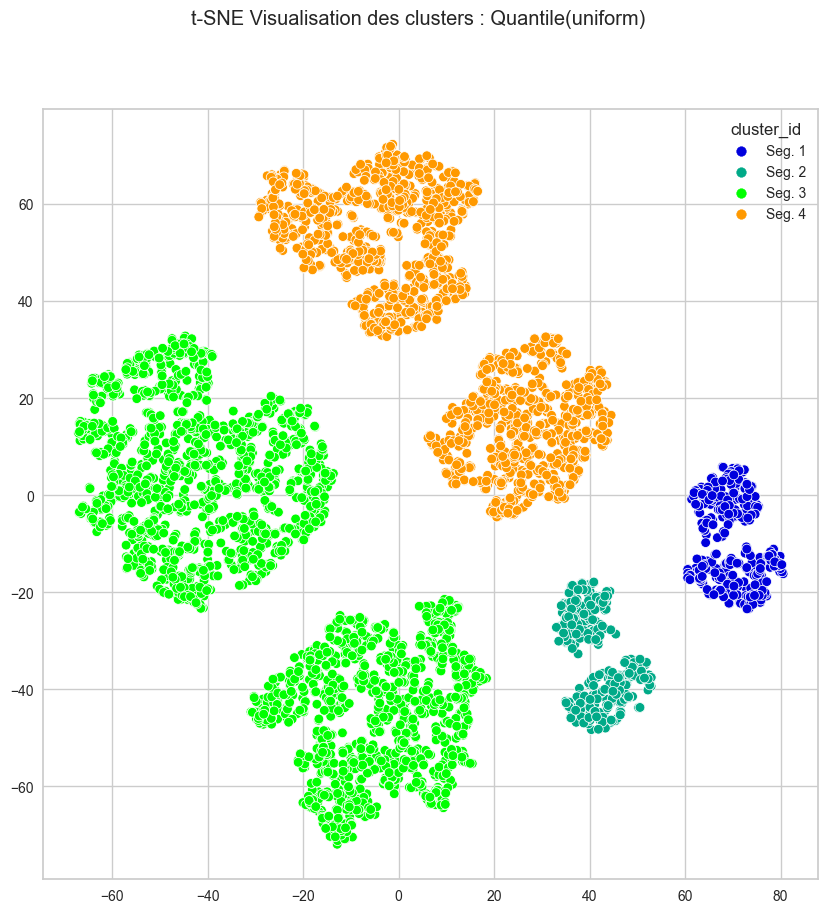

In [51]:
from sklearn.manifold import TSNE

pre_quant_uniform = QuantileTransformer(
    output_distribution='uniform', random_state=0)
pre_quant_normal = QuantileTransformer(
    output_distribution='normal', random_state=0)


def calc_tsne(df: pd.DataFrame, preprocessor=pre_quant_uniform, cluster_col='cluster_id',
              sample_size=5000, perplexity=30, random_state=0):
    """Calcule une visualisation de données basé sur preprocessing """
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('tsne', TSNE(n_components=2, perplexity=perplexity,
         verbose=0, init='pca', random_state=random_state))
    ])
    sample_size = min(sample_size, len(df))
    df_sample = df.sample(sample_size, random_state=random_state)
    if cluster_col in df_sample:
        df_sample[cluster_col] = df[cluster_col].astype('category')
    tsne = model.fit_transform(df_sample.select_dtypes('number'))
    return df_sample, tsne


def plot_tsne(df: pd.DataFrame, tsne, hue_col='cluster_id'):
    """
    Visualise les clusters sur les premier 2 components d'un tSNE déjà calculé 
    """
    if hue_col=='cluster_id':
        hue_order = calc_cluster_order_score(df, cluster_col=hue_col)
    else:
        hue_order=None
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1],
                    hue=df[hue_col].astype(str), hue_order=hue_order, palette='nipy_spectral')


def run_fit_plot_tsne(df: pd.DataFrame, preprocessor=pre_quant_uniform,
                      cluster_col='cluster_id', hue_col='cluster_id',
                      sample_size=5000, perplexity=30, random_state=0):
    """
    Fit t-SNE, puis visualise les clusters sur les premier 2 components du tSNE 
    """
    sample_df, tsne = calc_tsne(
        df, preprocessor, cluster_col, sample_size, perplexity, random_state)
    plot_tsne(sample_df, tsne, hue_col)
    return sample_df, tsne


sample_df, tsne = run_fit_plot_tsne(client_clusters_cah.pipe(
    rename_cluster_labels), preprocessor=pre_quant_uniform)
plt.suptitle('t-SNE Visualisation des clusters : Quantile(uniform)')


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN est une méthode de clustering qui se base sur la densité des points de données dans l'espace.  
Elle identifie les régions de l'espace où la densité des points est élevée comme des clusters, tandis que les zones moins denses sont considérées comme du bruit ou des points aberrants.  
DBSCAN ne nécessite pas de spécifier à l'avance le nombre de clusters à trouver.  
Elle peut gérer des clusters de formes arbitraires et est robuste aux valeurs aberrantes.  
DBSCAN est particulièrement utile lorsque les clusters ont des formes complexes ou lorsque la densité des points varie à travers l'espace.  


#### Hyperparamètres
- epsilon (eps) : distance maximale entre deux échantillons pour qu'ils soient considérés dans le même cluster. Au dessus de cette distance, les autres points sont ignorés (du bruit)
- min_samples : nombre minimum d'échantillons requis pour former un cluster


#### Epsilon
La valeur d'epsilon dépend de la métrique de distance utilisé et du preprocessing des features appliqué.
- si epsilon trop bas -> beaucoup de petit clusters : on risque de ne trouver pas des segmentations globals; les clusters peuvent être instables
- si epsilon trop haut -> beacoup de bruit : on risque de ne pas detecter de nuances entre les clusters

#### Min samples
min samples: nombre minimum d'échantillons requis pour former un cluster
- min_samples trop bas -> on risque de crée des trop petit clusters
- min_samples trop haut -> on risque de ne pas detecter pas les groupes plus petits


In [52]:
from math import pi
from matplotlib.figure import Figure
from matplotlib.projections import PolarAxes

CLUSTER_PALETTE = 'nipy_spectral'

def plot_spider(df_cluster_summary: pd.DataFrame, features=FEATURES, 
cluster_col='cluster_id', segment_labels=None):
    """
    Plot cluster summary as spider plots
    - cluster order based on 'total_score' column in cluster_summary
    Based on https://python-graph-gallery.com/390-basic-radar-chart
    """
    df_to_plot_std = standard_scores(
        df_cluster_summary, features, min_score=1, max_score=5)

    df_to_plot_std = (df_to_plot_std
                      .pipe(calc_total_score)
                      .pipe(rename_cluster_labels)
                      .sort_values(by=cluster_col)
                      .reset_index())
    
    if not segment_labels is None:
        old_labels=sorted(list(df_to_plot_std[cluster_col]))
        label_map=dict(zip(old_labels,segment_labels))
        df_to_plot_std[cluster_col]=df_to_plot_std[cluster_col].map(label_map)

    n_clusters = df_to_plot_std[cluster_col].nunique()

    color = sns.color_palette(CLUSTER_PALETTE, n_colors=n_clusters)

    # angles
    n_features = len(features)
    angles = [n / float(n_features) * 2 * pi for n in range(n_features)]
    angles += angles[:1]  # close plot

    n_cols = 4
    n_rows = n_clusters // n_cols + (n_clusters % n_cols > 0)
    fig: Figure = plt.figure(1, figsize=(n_cols*4, n_rows*4))

    segments = list(df_to_plot_std[cluster_col])
    # debug
    # print(df_to_plot_std[[cluster_col, 'cluster_pct',
    #       'total_score', 'MonetaryValue', 'Frequency']])

    for i, segment in enumerate(segments):
        ax: PolarAxes = fig.add_subplot(n_rows, n_cols, i + 1, polar=True)

        # We are going to plot the first line of the data frame.
        values = list(df_to_plot_std.loc[i][features].values)
        values += values[:1]  # repeat 1st feature to close radar plot
        pct = df_to_plot_std.loc[i]['cluster_pct']
        ax.set_title(f'{segment} ({pct:.1f} %)', color=color[i], fontdict={
                     "fontsize": 15, "fontweight": "bold"})
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)

        # Draw one axe per variable + add labels
        plt.xticks(angles[:-1], features, color="grey", size=8)
        ax.set_xticklabels(features, size=12)

        # Draw ylabels
        ax.set_rlabel_position(0)
        ax.set_rlim((0, 5))
        # r axis is a transformation of the y_axis
        # ax.set_ylim((0,5))
        ax.set_rgrids(range(1, 5))

        # Plot data
        ax.plot(angles, values, color=color[i], marker="o", lw=1, ls="solid")

        # Fill area
        ax.fill(angles, values, color=color[i], alpha=.25)
    plt.subplots_adjust(hspace=0.25, wspace=1.02)

    pct = df_to_plot_std['cluster_pct'].to_dict()
    pct = {f'seg {k}': v for k, v in pct.items()}
    # pct = pd.DataFrame({f'seg {k}': v for k, v in pct.items()})

    return pct

Regroupement des données en clusters avec DBSCAN et visualisation des graphiques en toile d'araignée (radar plots) 
avec eps= 2 et min_samples=100 

 0    5117
 1    2642
 3     738
 4     701
 2     481
 5     233
-1      88
Name: count, dtype: int64
{'-1': 'Seg. 1', '5': 'Seg. 2', '2': 'Seg. 3', '3': 'Seg. 4', '4': 'Seg. 5', '0': 'Seg. 6', '1': 'Seg. 7'}
{'Seg. 1': 'Seg. 1', 'Seg. 2': 'Seg. 2', 'Seg. 3': 'Seg. 3', 'Seg. 4': 'Seg. 4', 'Seg. 5': 'Seg. 5', 'Seg. 6': 'Seg. 6', 'Seg. 7': 'Seg. 7'}


{'seg 0': 0.88,
 'seg 1': 2.33,
 'seg 2': 4.81,
 'seg 3': 7.38,
 'seg 4': 7.01,
 'seg 5': 51.17,
 'seg 6': 26.42}

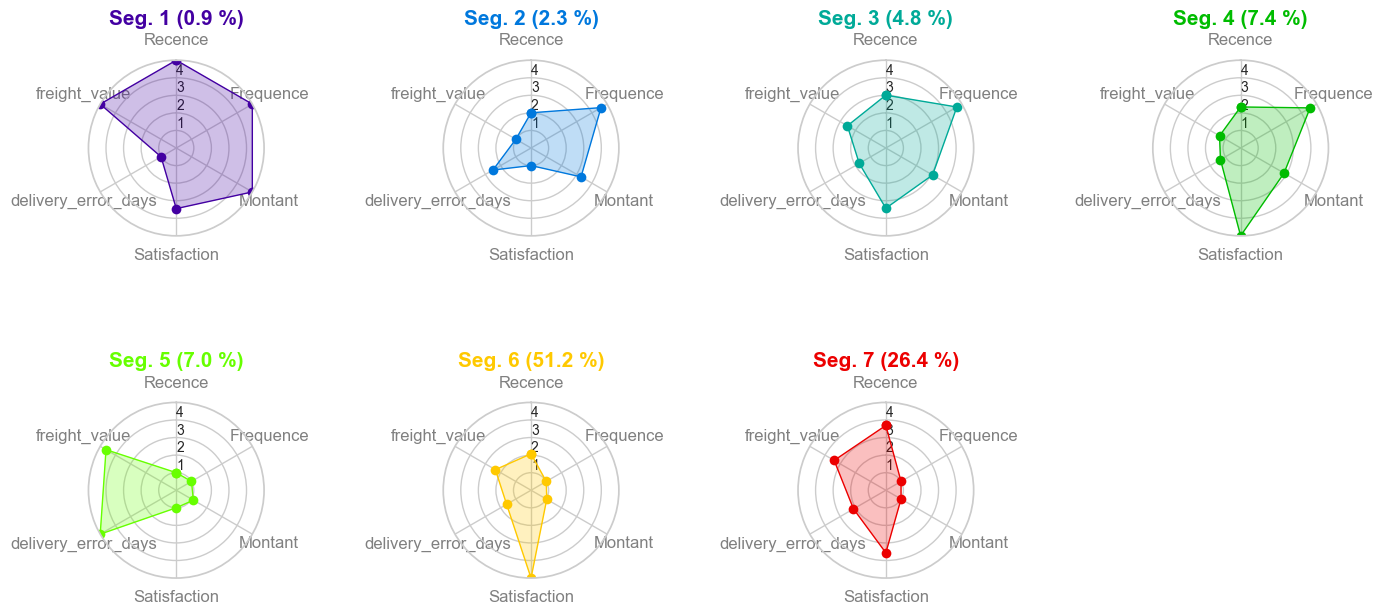

In [53]:
from sklearn.cluster import DBSCAN

model_dbscan = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal')),
    ('clf', DBSCAN(eps=2, min_samples=100))
])


def run_fit_labels(df: pd.DataFrame, model=model_dbscan, features=FEATURES):
    df = df.copy()
    model.fit(df[features])
    clf = model.named_steps['clf']
    print(pd.Series(clf.labels_).value_counts())
    df['cluster_id'] = clf.labels_
    return df


client_clusters_dbscan = run_fit_labels(df_clients_sample, model_dbscan).pipe(rename_cluster_labels)
client_groups = group_clusters(client_clusters_dbscan)

plot_spider(client_groups, features=FEATURES)


 0    5146
 1    3361
 3     748
 2     525
-1     220
Name: count, dtype: int64
{'-1': 'Seg. 1', '2': 'Seg. 2', '3': 'Seg. 3', '0': 'Seg. 4', '1': 'Seg. 5'}
{'Seg. 1': 'Seg. 1', 'Seg. 2': 'Seg. 2', 'Seg. 3': 'Seg. 3', 'Seg. 4': 'Seg. 4', 'Seg. 5': 'Seg. 5'}


{'seg 0': 2.2, 'seg 1': 5.25, 'seg 2': 7.48, 'seg 3': 51.46, 'seg 4': 33.61}

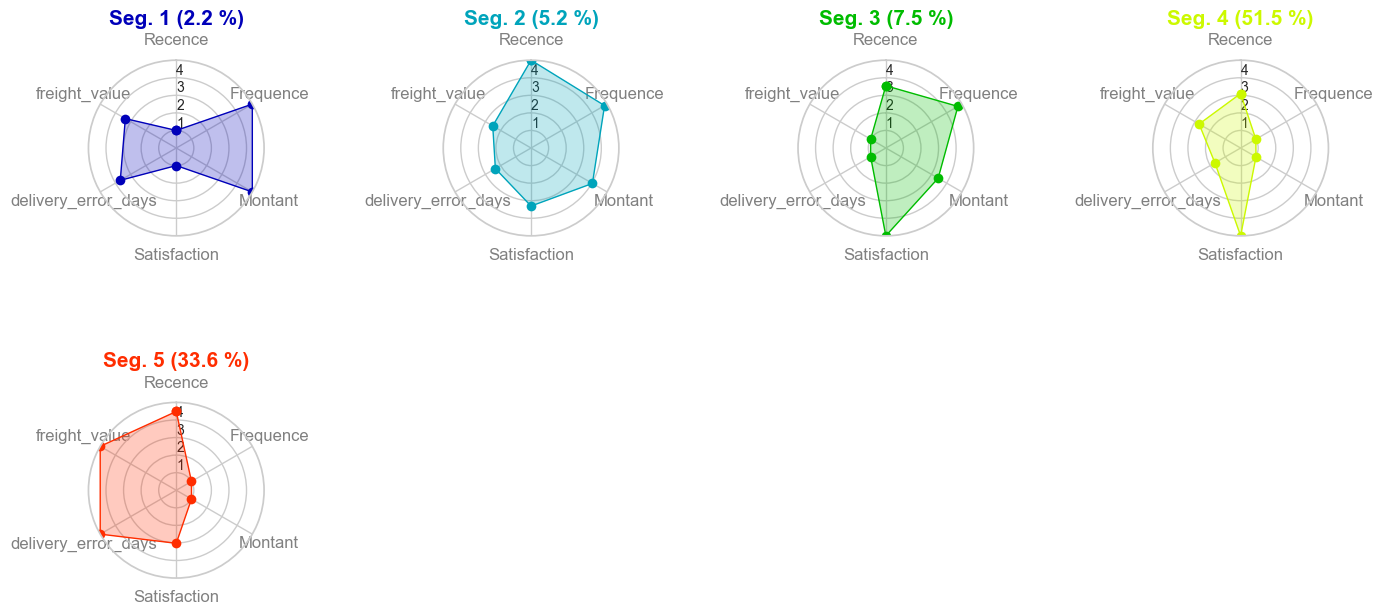

In [54]:
from sklearn.cluster import DBSCAN

model_dbscan = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal')),
    ('clf', DBSCAN(eps=4, min_samples=300))
])


def run_fit_labels(df: pd.DataFrame, model=model_dbscan, features=FEATURES):
    df = df.copy()
    model.fit(df[features])
    clf = model.named_steps['clf']
    print(pd.Series(clf.labels_).value_counts())
    df['cluster_id'] = clf.labels_
    return df


client_clusters_dbscan = run_fit_labels(df_clients_sample, model_dbscan).pipe(rename_cluster_labels)
client_groups = group_clusters(client_clusters_dbscan)

plot_spider(client_groups, features=FEATURES)


Text(0.5, 1.0, 'DBSCAN : Choice of epsilon (elbow method)')

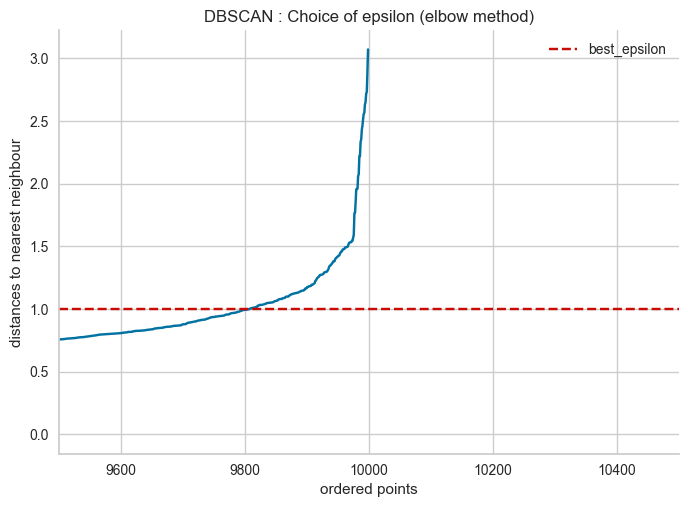

In [55]:
from sklearn.neighbors import NearestNeighbors


def best_epsilon(df, preprocessor=QuantileTransformer(output_distribution='normal')):
    X = pd.DataFrame(preprocessor.fit_transform(df))
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    n = X.shape[0]
    plt.xlim((n*0.95, n*1.05))
    plt.xlabel('ordered points')
    plt.ylabel('distances to nearest neighbour')
    sns.despine()


best_epsilon(df_clients_sample[FEATURES])
plt.axhline(1, c='r', ls='--', label='best_epsilon')
plt.legend()
plt.title('DBSCAN : Choice of epsilon (elbow method)')


In [56]:

param_grid = {
    'clf__eps': [0.5, 0.75, 1, 2, 4],
    'clf__min_samples': [10, 20, 50, 100, 200]
}
scores_dbscan = score_model(
    df=df_clients_sample[FEATURES], model=model_dbscan, param_grid=param_grid)


params={'clf__eps': 0.5, 'clf__min_samples': 10}; k=13; cluster_sizes=[48, 42, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
params={'clf__eps': 0.5, 'clf__min_samples': 20}; k=7; cluster_sizes=[65, 32, 2, 0, 0, 0, 0]
params={'clf__eps': 0.5, 'clf__min_samples': 50}; k=2; cluster_sizes=[91, 9]
params={'clf__eps': 0.75, 'clf__min_samples': 10}; k=12; cluster_sizes=[50, 24, 15, 4, 4, 1, 1, 0, 0, 0, 0, 0]
params={'clf__eps': 0.75, 'clf__min_samples': 20}; k=5; cluster_sizes=[49, 25, 22, 3, 2]
params={'clf__eps': 0.75, 'clf__min_samples': 50}; k=4; cluster_sizes=[44, 43, 12, 1]
params={'clf__eps': 0.75, 'clf__min_samples': 100}; k=3; cluster_sizes=[63, 35, 3]
params={'clf__eps': 0.75, 'clf__min_samples': 200}; k=2; cluster_sizes=[85, 15]
params={'clf__eps': 1, 'clf__min_samples': 10}; k=8; cluster_sizes=[51, 26, 6, 6, 5, 3, 2, 0]
params={'clf__eps': 1, 'clf__min_samples': 20}; k=7; cluster_sizes=[51, 26, 8, 6, 6, 2, 1]
params={'clf__eps': 1, 'clf__min_samples': 50}; k=5; cluster_sizes=[50, 24, 19, 4, 3

In [57]:
scores_dbscan['clf__eps'] = scores_dbscan['clf__eps'].astype('category')
(scores_dbscan[['clf__eps', 'clf__min_samples', 'davies_bouldin',
            'silhouette_score', 'k', 'cluster_sizes']]
 .sort_values(by='silhouette_score', ascending=False)
 ).head()

,clf__eps,clf__min_samples,davies_bouldin,silhouette_score,k,cluster_sizes
23,4.0,100.0,0.705776,0.58,4,"[51, 34, 7, 7]"
22,4.0,50.0,0.705776,0.58,4,"[51, 34, 7, 7]"
21,4.0,20.0,0.705776,0.58,4,"[51, 34, 7, 7]"
20,4.0,10.0,0.705776,0.58,4,"[51, 34, 7, 7]"
15,2.0,10.0,1.586214,0.56,8,"[51, 26, 7, 7, 5, 2, 0, 0]"


Text(0.5, 0.98, 'DBSCAN - effet de [eps, min_samples] sur silhouette score')

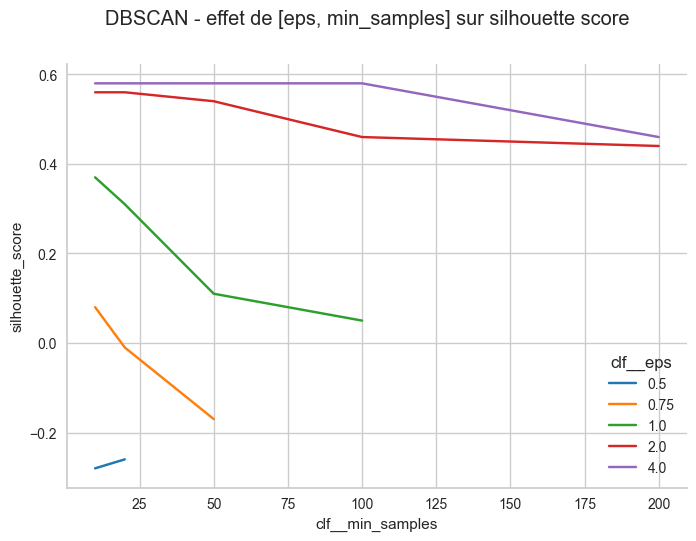

In [58]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='silhouette_score', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur silhouette score')

Text(0.5, 0.98, 'DBSCAN - effet de [eps, min_samples] sur davies_bouldin score')

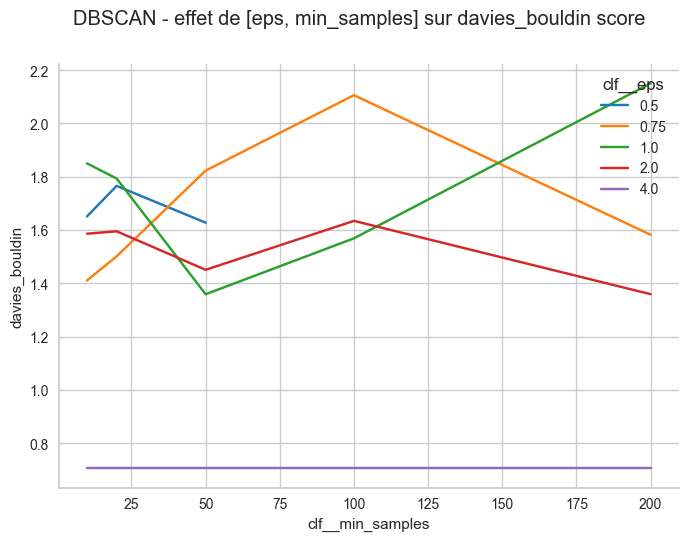

In [59]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='davies_bouldin', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur davies_bouldin score')

Text(0.5, 0.98, 'DBSCAN - effet de [eps, min_samples] sur calinski_harabasz')

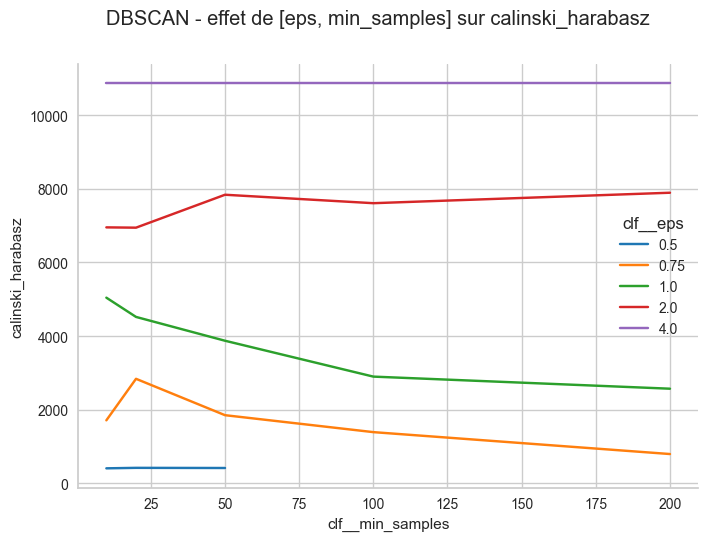

In [60]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='calinski_harabasz', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur calinski_harabasz')

Text(0.5, 0.98, 'DBSCAN - effet de [eps, min_samples] sur fit time')

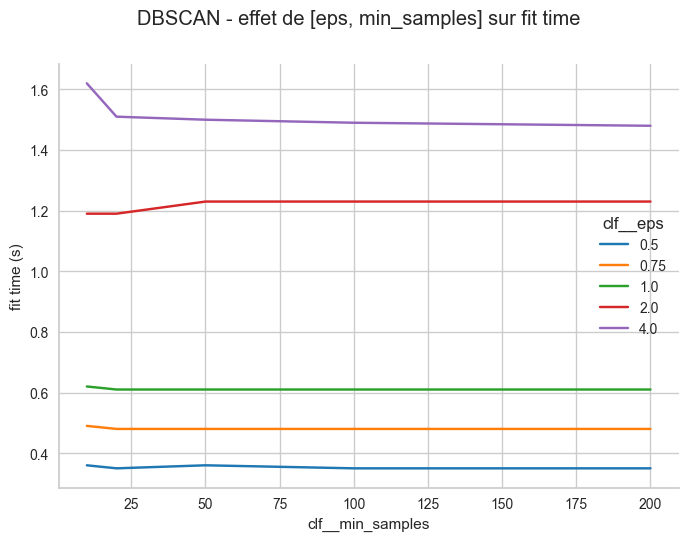

In [61]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='fit time (s)', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur fit time')

Les meilleurs résultats pour DBSCAN semblent être pour eps=4 :

- haut silhouette score
- bas davies_bouldin
- haut valeur calinski harabasz


In [62]:
scores_dbscan[scores_dbscan['clf__eps'] == 4]

,k,davies_bouldin,calinski_harabasz,silhouette_score,silhouette_score_std,silhouette_sample_sizes,silhouette_time,clf,preprocessor,fit time (s),cluster_sizes,clf__eps,clf__min_samples,stability_score,stability_score_std,stability_sample_sizes,stability_time
20,4,0.705776,10862.273064,0.58,0.00,2000,1.42,DBSCAN,QuantileTransformer,1.62,"[51, 34, 7, 7]",4.0,10.0,1.0,0.0,10000.0,15.25
21,4,0.705776,10862.273064,0.58,0.01,2000,1.32,DBSCAN,QuantileTransformer,1.51,"[51, 34, 7, 7]",4.0,20.0,1.0,0.0,10000.0,15.02
22,4,0.705776,10862.273064,0.58,0.00,2000,1.40,DBSCAN,QuantileTransformer,1.50,"[51, 34, 7, 7]",4.0,50.0,1.0,0.0,10000.0,14.77
23,4,0.705776,10862.273064,0.58,0.00,2000,1.30,DBSCAN,QuantileTransformer,1.49,"[51, 34, 7, 7]",4.0,100.0,1.0,0.0,10000.0,14.61
24,4,0.705776,10862.273064,0.46,0.00,2000,1.30,DBSCAN,QuantileTransformer,1.48,"[51, 34, 7, 7]",4.0,200.0,1.0,0.0,10000.0,14.62


0    5146
1    3361
3     748
2     745
Name: count, dtype: int64
{'2': 'Seg. 1', '3': 'Seg. 2', '0': 'Seg. 3', '1': 'Seg. 4'}


Text(0.5, 0.98, "Clusters trouvé par DBSCAN (eps=2, min_samples=100, features=['Recence', 'Frequence', 'Montant', 'Satisfaction', 'delivery_error_days', 'freight_value']")

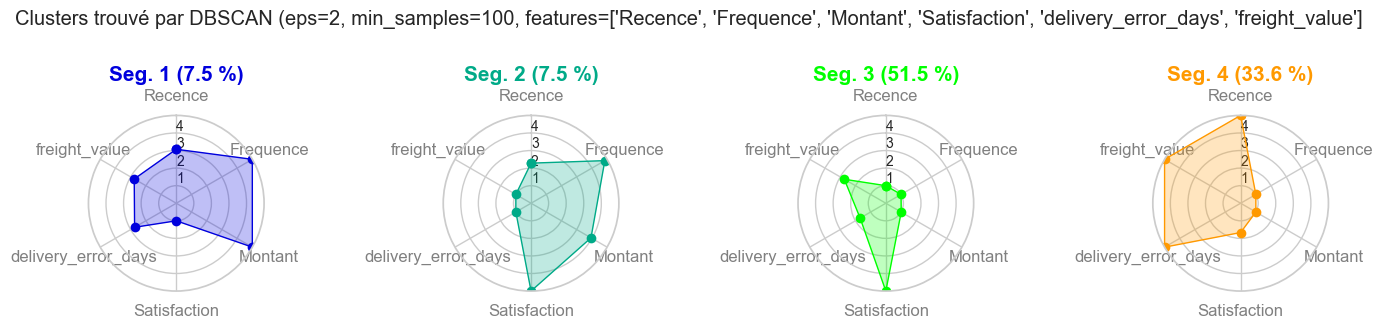

In [63]:
from sklearn.cluster import DBSCAN

model_dbscan = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(
        output_distribution='normal', random_state=0)),
    ('clf', DBSCAN(eps=4, min_samples=200))
])


def run_fit_labels(df: pd.DataFrame, model=model_dbscan, features=FEATURES):
    """shortcut to run model and return dataset with fitted cluster labels"""
    df = df.copy()
    model.fit(df[features])
    clf = model.named_steps['clf']
    print(pd.Series(clf.labels_).value_counts())
    df['cluster_id'] = clf.labels_
    return df

client_clusters_dbscan = run_fit_labels(df_clients_sample, model_dbscan)
client_groups = group_clusters(client_clusters_dbscan)
plot_spider(client_groups, features=FEATURES)
plt.suptitle(
    f'Clusters trouvé par DBSCAN (eps=2, min_samples=100, features={FEATURES}')
